
SSO STATION KEEPING


- Burning time = 946999.108982068 s
- Delta V = 0.022727978615569633

Process finished --- 356 seconds
Timestep 15650.6203 ss
Run time 356.96s/5.95m


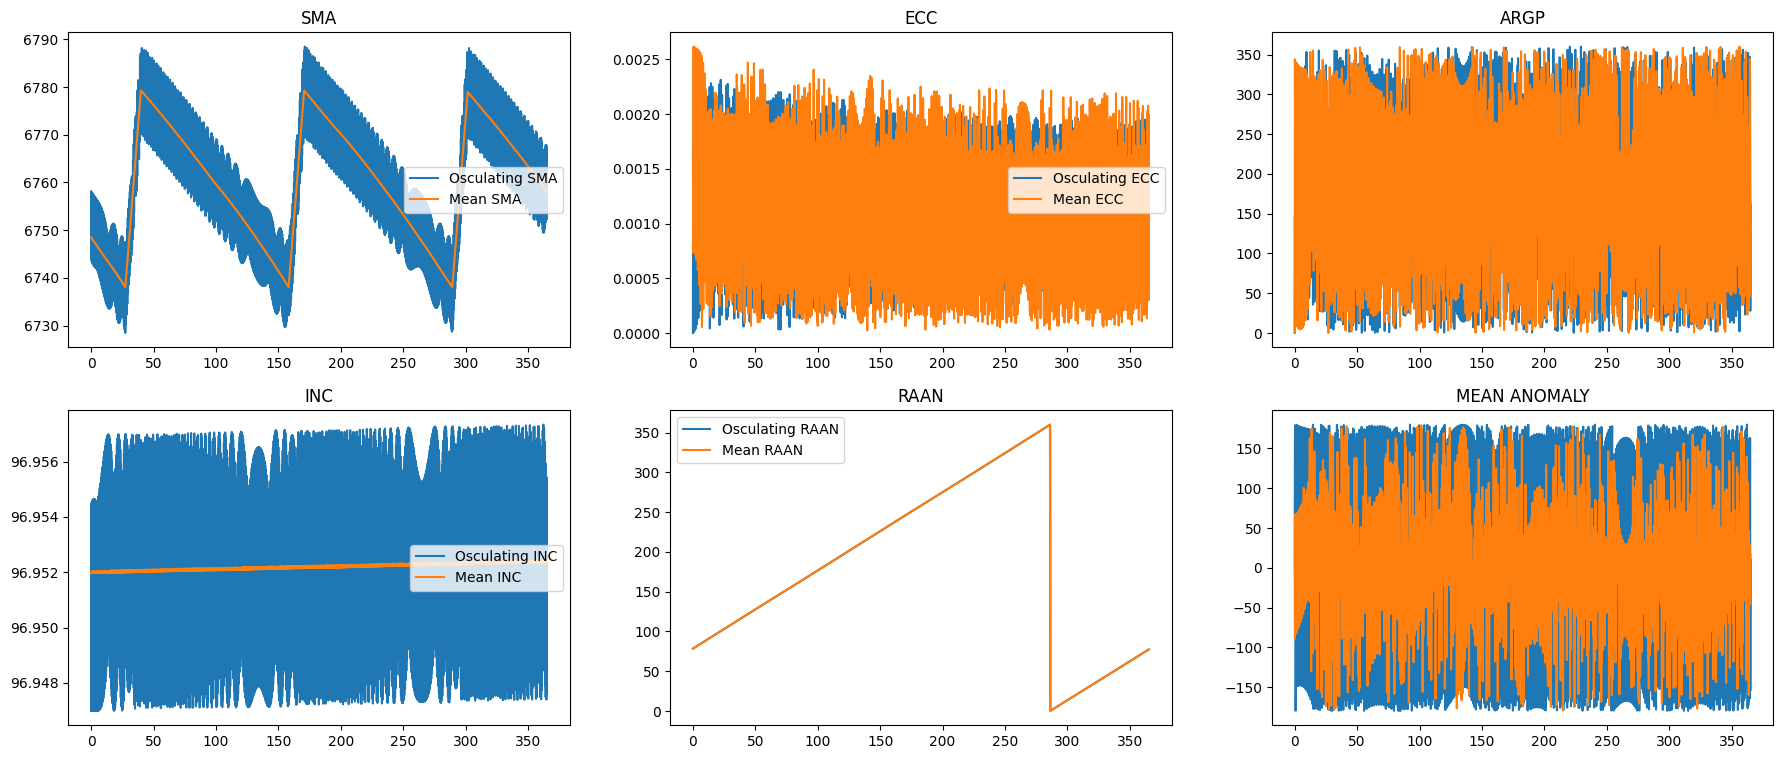

In [5]:
from astropy import units as u
from astropy.time import Time, TimeDelta

from poliastro.bodies import Earth
from poliastro.constants import rho0_earth, H0_earth
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import CowellPropagator
from poliastro.twobody.thrust import change_a_inc
from poliastro.core.perturbations import J2_perturbation
from poliastro.core.propagation import func_twobody 
from poliastro.util import Time

from datetime import datetime, timedelta

import numpy as np

import matplotlib.pyplot as plt

import time

from sso_inc_sk import inc_from_alt, raan_from_ltan
from perturbations_sk import coesa76_model

from mean_elements_sk import osc2mean

print('\nSSO STATION KEEPING\n')

toc = time.time()

process_start_time = time.time()   # start time of python code


# Constants
R = Earth.R.to(u.km).value
k = Earth.k.to(u.km**3 / u.s**2)
k_val = k.value
J2 = Earth.J2.value

rho0 = rho0_earth.to(u.kg/u.km**3).value
H0   = H0_earth.to(u.km).value

# GMAT correct RHW orbit decay was for: C_D = 2.2, A = 0.02 m^2, m = 2.205 kg
C_D = 2.2
A_over_m = ((0.01 * u.m**2) / (2.5 * u.kg)).to_value(u.km**2 / u.kg)   # km**2/kg
B = C_D * A_over_m   # ballistic coefficient at low drag mode

# Definition of the initial orbit (poliastro)
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

a = (R + 380) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(380,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

epoch = Time(val=start_date.isoformat(), format='isot')

start_date_ts = datetime.timestamp(start_date)
stop_date_ts = datetime.timestamp(start_date + timedelta(hours = 24*365))
sample_num = 9*1*16*7*2
timestamps = np.linspace(start_date_ts, stop_date_ts, sample_num)
time_step = (timestamps[1]-timestamps[0]) << u.s

in_orbit = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu, epoch)

a_list     = [in_orbit.a.value]
ecc_list   = [in_orbit.ecc.value]
inc_list   = [in_orbit.inc.value]
raan_list  = [in_orbit.raan.value]
argp_list  = [in_orbit.argp.value]
nu_list    = [in_orbit.nu.value]
epoch_list = [in_orbit.epoch.value]

secs = 0
elapsedsecs = [0]

a_up   = (R + 400)<<u.km
a_down = (R + 360)<<u.km 
inc_up = inc_from_alt(400,ecc)[0] << u.deg
inc_down = inc_from_alt(360,ecc)[0] << u.deg

acc = 2.4e-8 * (u.km / u.s**2)


def a_d(t0, state, k, J2, R, C_D, A_over_m):

    return J2_perturbation(
        t0, state, k, J2, R
        ) + coesa76_model(
            state, R, C_D, A_over_m
            )

a_d_thrust, deltaV, t_f = change_a_inc(k, a_down, a_up, inc_up, inc_up, acc)

def f_thrust(t0, state, k):

    du_kep = func_twobody(t0, state, k)
    ax, ay, az = a_d(
        t0, 
        state, 
        k=k_val,
        J2=J2, 
        R = R, 
        C_D = C_D, 
        A_over_m = A_over_m
        )
    
    ax_t, ay_t, az_t = a_d_thrust(t0,
                                  state,
                                  k=k)
    
    du_ad = np.array([0, 0, 0, ax+ax_t, ay+ay_t, az+az_t])

    return du_kep + du_ad

def f_no_thrust(t0, state, k):

    du_kep = func_twobody(t0, state, k)
    ax, ay, az = a_d(
        t0, 
        state, 
        k=k_val,
        J2=J2, 
        R = R, 
        C_D = C_D, 
        A_over_m = A_over_m
        )
    
    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad



mean_elements = osc2mean(a_list[0], ecc_list[0], inc_list[0], raan_list[0], argp_list[0], nu_list[0])

a_mean_list = [mean_elements[0]]
ecc_mean_list = [mean_elements[1]]
inc_mean_list = [mean_elements[2]]
raan_mean_list = [mean_elements[3]]
argp_mean_list = [mean_elements[4]]
nu_mean_list = [mean_elements[5]]

sat_orbit = in_orbit

no_maneuver = True

for timestamp in range(len(timestamps)):
    secs += time_step.value
    if  mean_elements[0] > a_down.value and no_maneuver:
        sat_orbit = sat_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=f_no_thrust))
    else:
        no_maneuver = False
        sat_orbit = sat_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=f_thrust))
        if mean_elements[0] > a_up.value:
            no_maneuver = True

    elapsedsecs.append(secs)

    a_list.append(sat_orbit.a.value)
    ecc_list.append(sat_orbit.ecc.value)
    inc_list.append(sat_orbit.inc.to_value(u.deg))
    raan_list.append(sat_orbit.raan.to_value(u.deg))
    argp_list.append(sat_orbit.argp.to_value(u.deg))
    nu_list.append(sat_orbit.nu.to_value(u.deg))

    mean_elements = osc2mean(
        sat_orbit.a.value, 
        sat_orbit.ecc.value, 
        sat_orbit.inc.to_value(u.deg), 
        sat_orbit.raan.to_value(u.deg), 
        sat_orbit.argp.to_value(u.deg), 
        sat_orbit.nu.to_value(u.deg)
        )

    a_mean_list.append(mean_elements[0])
    ecc_mean_list.append(mean_elements[1])
    inc_mean_list.append(mean_elements[2])
    raan_mean_list.append(mean_elements[3])
    argp_mean_list.append(mean_elements[4])
    nu_mean_list.append(mean_elements[5])



print(f'\n- Burning time = {t_f}\n- Delta V = {deltaV}')
print(f'\nProcess finished --- {int(time.time() - process_start_time)} seconds')

elapsed_days = []
for sec in range(len(elapsedsecs)):
    elapsed_days.append(elapsedsecs[sec]/(60*60*24))

fig, ax = plt.subplots(2, 3, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsed_days, a_list, label='Osculating SMA')
ax[0,0].plot(elapsed_days, a_mean_list, label='Mean SMA')
ax[0,0].legend(loc = 'center right')
ax[0,0].set_title('SMA')

ax[0,1].plot(elapsed_days, ecc_list, label='Osculating ECC')
ax[0,1].plot(elapsed_days, ecc_mean_list, label='Mean ECC')
ax[0,1].legend(loc = 'center right')
ax[0,1].set_title('ECC')

ax[1,0].plot(elapsed_days, inc_list, label='Osculating INC')
ax[1,0].plot(elapsed_days, inc_mean_list, label='Mean INC')
ax[1,0].legend(loc = 'center right')
ax[1,0].set_title('INC')

ax[1,1].plot(elapsed_days, raan_list, label='Osculating RAAN')
ax[1,1].plot(elapsed_days, raan_mean_list, label='Mean RAAN')
ax[1,1].legend(loc = 'upper left')
ax[1,1].set_title('RAAN')

ax[0,2].plot(elapsed_days,argp_list, label='Osculating ARGP')
ax[0,2].plot(elapsed_days, argp_mean_list, label='Mean ARGP')
ax[0,2].set_title('ARGP')

ax[1,2].plot(elapsed_days, nu_list, label='Osculating TA')
ax[1,2].plot(elapsed_days, nu_mean_list, label='Mean TA')
ax[1,2].set_title('MEAN ANOMALY')

# plt.show(block=True)

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()

Timestep 15650.6203 ss
Run time 9975.86s/166.26m


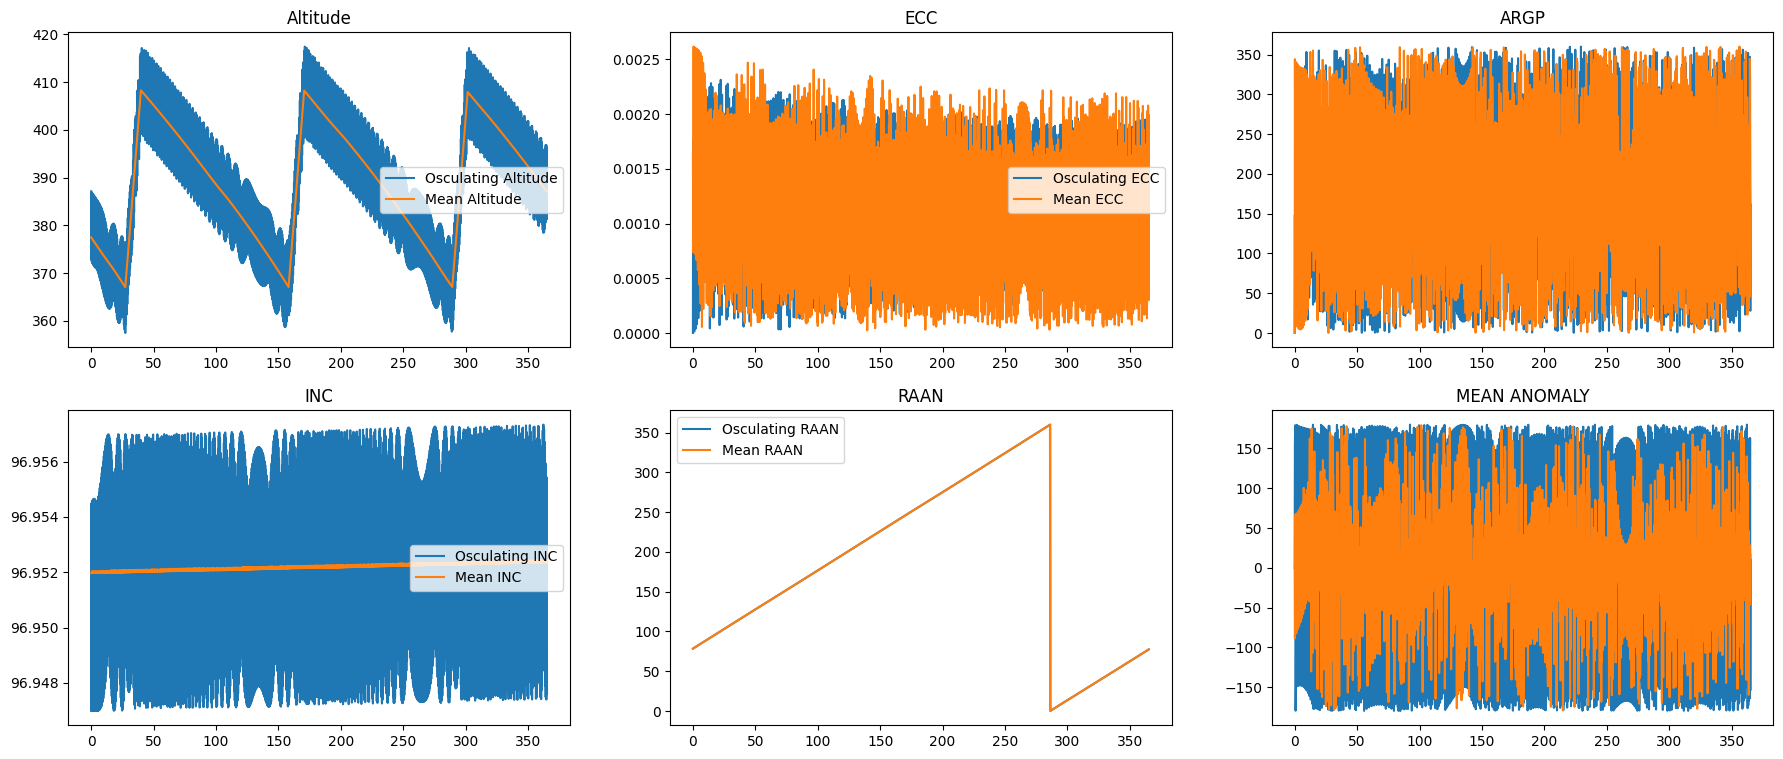

In [9]:
altitudes = []
mean_altitudes = []
for sma in range(len(a_list)):
    altitudes.append(a_list[sma] - Earth.R_mean.to_value(u.km))
    mean_altitudes.append(a_mean_list[sma] - Earth.R_mean.to_value(u.km))

fig, ax = plt.subplots(2, 3, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsed_days, altitudes, label='Osculating Altitude')
ax[0,0].plot(elapsed_days, mean_altitudes, label='Mean Altitude')
ax[0,0].legend(loc = 'center right')
ax[0,0].set_title('Altitude')

ax[0,1].plot(elapsed_days, ecc_list, label='Osculating ECC')
ax[0,1].plot(elapsed_days, ecc_mean_list, label='Mean ECC')
ax[0,1].legend(loc = 'center right')
ax[0,1].set_title('ECC')

ax[1,0].plot(elapsed_days, inc_list, label='Osculating INC')
ax[1,0].plot(elapsed_days, inc_mean_list, label='Mean INC')
ax[1,0].legend(loc = 'center right')
ax[1,0].set_title('INC')

ax[1,1].plot(elapsed_days, raan_list, label='Osculating RAAN')
ax[1,1].plot(elapsed_days, raan_mean_list, label='Mean RAAN')
ax[1,1].legend(loc = 'upper left')
ax[1,1].set_title('RAAN')

ax[0,2].plot(elapsed_days,argp_list, label='Osculating ARGP')
ax[0,2].plot(elapsed_days, argp_mean_list, label='Mean ARGP')
ax[0,2].set_title('ARGP')

ax[1,2].plot(elapsed_days, nu_list, label='Osculating TA')
ax[1,2].plot(elapsed_days, nu_mean_list, label='Mean TA')
ax[1,2].set_title('MEAN ANOMALY')

# plt.show(block=True)

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()